# Training the Neural Network

$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

In [3]:
from gaussian import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import tensorboard as tb

%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


We will train a neural network with `torch` and use GPU if available:

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE == "cuda":  # print current GPU name if available
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using GPU: Tesla T4


- https://pytorch.org/docs/stable/notes/randomness.html
- https://pytorch.org/docs/stable/cuda.html?highlight=cuda#module-torch.cuda

When GPU is available, you can use GPU DASHBOARDS on the left to monitor GPU utilizations.

![GPU](gpu.dio.svg)

**How to train a neural network by gradient descent?**

We will first consider a simple implementation.

## A simple implementation of gradient descent

For simplicity, suppose we want to apply gradient descend algorithm to solve

$$ \inf_{w\in \mathbb{R}} \overbrace{e^{w\cdot z}}^{L(w):=}$$

for a given $z\in \mathbb{R}$. This can be viewed as training a simple neural network with one parameter, namely, $w$, to minimize the loss function $L(w)$.

Consider $z=-1$ in particular. Then, 

$$
L(w) = e^{-w} \geq 0
$$

which is achievable with equality as $w\to \infty$. The following implements the loss function:

**How to implement the loss function?**

We will define the loss function using tensors:

In [5]:
z = Tensor([-1]).to(DEVICE)  # default tensor type on a designated device


def L(w):
    return (w * z).exp()


L(float("inf"))

tensor([0.], device='cuda:0')

The function `L` is vectorized because Tensor follows the [broadcasting rules of `numpy`](https://numpy.org/doc/stable/user/basics.broadcasting.html):

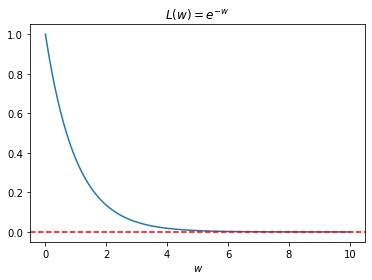

In [6]:
ww = np.linspace(0, 10, 100)
ax = sns.lineplot(
    x=ww,
    y=L(Tensor(ww).to(DEVICE)).cpu().numpy(),  # convert to numpy array for plotting
)
ax.set(xlabel=r"$w$", title=r"$L(w)=e^{-w}$")
ax.axhline(L(float("inf")), ls="--", c="r")

**What is gradient descent?**

A gradient descent algorithm updates the parameter $w$ iteratively starting with some initial weight $w^{(0)}$ as follows:

$$w^{(i+1)} = w^{(i)} - s^{(i)} \nabla L(w^{(i)}) \qquad \text{for }i\geq 0,$$

where $s$ is a small step size (or *learning rate*). For simplicity, fix $s^{(i)}=0.001$ independent of $i$.

**How to compute the gradient?**

With $w^{(0)}=0$, 

$$\nabla L(w^{(0)}) = \left.-e^{-w}\right|_{w=0}=-1,$$ 

which can be computed using `backward` ([backpropagation][bp]):

[bp]: https://en.wikipedia.org/wiki/Backpropagation

In [7]:
w = Tensor([0]).to(DEVICE).requires_grad_()  # requires gradient calculation for w
L(w).backward()  # calculate the gradient by backpropagation
w.grad

tensor([-1.], device='cuda:0')

Under the hood, a computational graph is generated for backpropagation to the parameters that requires gradient calculations.

**How to implement the gradient descent?**

The following implements the gradient algorithm with a learning rate of `0.001`:

In [8]:
for i in range(1000):
    w.grad = None  # zero the gradient to avoid accumulation
    L(w).backward()
    w.grad
    with torch.no_grad():  # updates the weights in place without gradient calculation
        w -= w.grad * 1e-3

print("w:", w.item(), "\nL(w):", L(w).item())

w: 0.6933202147483826 
L(w): 0.4999134838581085


[`with torch.no_grad():`][no_grad] sets up a context where computations are not recorded in the computational graph for backpropagation. The weight update, in particular, should not be differentiated in the subsequent calculate of the gradient.

[no_grad]: https://pytorch.org/docs/stable/generated/torch.no_grad.html

**Exercise** 

Repeatedly run the above cell until you get `L(w)` below `0.001`. How large is the value of `w`? What is the limitations of the simple gradient descent algorithm?

**Solution** 

The value of `w` needs to be smaller than `6.9`. The convergence can be slow, especially when the learning rate is small. Also, `w` can be far away from its optimal value even if `L(w)` is close to its minimum.

## A practical implementation

For a neural network to fit a sophisticated function, it needs to have many degrees of freedom, i.e., number of parameters.

**How to define a neural network?**

The following code [defines a simple neural networks][define] with 3 fully-connected (fc) hidden layers:

![Neural net](nn.dio.svg)

where 

- $\M{W}_l$ and $\M{b}_l$ are the weight and bias respectively for the linear transformation $\R{W}_l a_l + b_l$ of the $l$-th layer; and
- $\sigma$ for the first 2 hidden layers is an activation function chosen to be the [*exponential linear unit (ELU)*](https://pytorch.org/docs/stable/generated/torch.nn.ELU.html).

[define]: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network

In [9]:
class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # fully-connected (fc) layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # layer 2
        self.fc3 = nn.Linear(hidden_size, 1)  # layer 3
        nn.init.normal_(self.fc1.weight, std=sigma)  #
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, z):
        a1 = F.elu(self.fc1(z))
        a2 = F.elu(self.fc2(a1))
        t = self.fc3(a2)
        return t


torch.manual_seed(SEED)  # seed RNG for PyTorch
net = Net()
net.to(DEVICE)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


The neural network is a vectorized function, i.e., we can pass in multiple values of $z$'s (along the first dimension) to obtain multiple $t(z)$'s. E.g., the following plots the density estimate of $t(\R{Z}_i)$'s and $t(\R{Z}'_i)$'s.

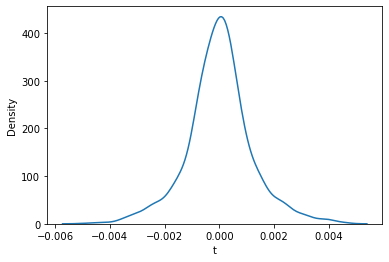

In [10]:
Z = Tensor(XY).to(DEVICE)
Z_ref = Tensor(XY_ref).to(DEVICE)

tZ = (
    net(torch.cat((Z, Z_ref), dim=0))  # compute t(Z_i)'s and t(Z'_i)
    # output needs to be converted back to an array on CPU for plotting
    .cpu()  # copy back to CPU
    .detach()  # detach from current graph (no gradient calculation)
    .numpy()  # convert output back to numpy
)

tZ_df = pd.DataFrame(data=tZ, columns=["t"])
sns.kdeplot(data=tZ_df, x="t")
plt.show()

**Exercise** 

Why are the values concentrated around $0$?

**Solution** 

The values are all very close to $0$ as we have set a small variance `sigma=0.02` to initialize the neural network parameters: 

- The linear transformation $\M{W}_l (\cdot) + \M{b}_l$ is close to $0$ for when the weight and bias are close to $0$. 
- The ELU activation function $\sigma$ is also close to $0$ if its input is close to $0$.

We can use the neural network to compute the approximate divergence lower bound in {eq}`avg-DV` as follows:

$$
\begin{align}
\R{L}(\theta) &:= \underbrace{\frac1{n} \sum_{i\in [n]} t(\R{Z}_i)}_{\text{(a)}} - \underbrace{\log \frac1{n'} \sum_{i\in [n']} e^{t(\R{Z}'_i)}}_{ \underbrace{\log \sum_{i\in [n']} e^{t(\R{Z}'_i)}}_{\text{(b)}} - \underbrace{\log n'}_{\text{(c)}}} 
\end{align}
$$

where $\theta$ is a tuple of parameters (weights and biases) of the neural network that computes $t$:

$$
\theta := (\M{W}_l,\M{b}_l|l\in [3]).
$$

In [11]:
def DV(Z, Z_ref, net):
    avg_tZ = net(Z).mean()  # (a)
    avg_etZ_ref = net(Z_ref).logsumexp(dim=0) - np.log(Z_ref.shape[0])  # (b) - (c)
    return avg_tZ - avg_etZ_ref


DV_estimate = DV(Z, Z_ref, net)

**Exercise** Why is it preferrable to use `logsumexp(dim=0)` instead of `.exp().mean().log()`?

**Solution** `logsumexp(dim=0)` is numerically more stable than `.exp().mean().log()` especially when the output of the exponential function is too large to be represented by the default floating point type. This can lead to an overall value of `NaN`, even if the output after taking the `mean()` and `log()` is representable.

To calculate the gradient of the divergence estimate with respect to $\theta$:

In [12]:
net.zero_grad()  # zero the gradient 
DV(Z, Z_ref, net).backward()  # calculate the gradient
a_param = next(net.parameters())

`a_param` is a (module) parameter in $\theta$ retrieved from the parameter iterator `parameters()`.

**Exercise** 

Check the value of `a_param.grad` is non-zero. Is `a_param` a weight or a bias?

**Solution** 

It should be the weight matrix $\M{W}_1$ because the shape is `torch.Size([100, 2])`.

We will use the [*Adam's* gradient descend algorithm][adam] implemented as an optimizer [`optim.Adam`][optimAdam]:

[adam]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent#cite_note-Adam2014-28
[optimAdam]: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [13]:
optimizer = optim.Adam(net.parameters())  # Allow Adam's optimizer to update the neural network parameters
optimizer.step() # perform one step of the gradient descent

To alleviate the problem of overfitting, the gradient is often calculated on randomly chosen batches of the samples:

![Minibatch gradient descent](batch.dio.svg)

In [14]:
n_iters_per_epoch = 10  # ideally a divisor of both n and n'
batch_size = int((Z.shape[0] + 0.5) / n_iters_per_epoch)
batch_size_ref = int((Z_ref.shape[0] + 0.5) / n_iters_per_epoch)

We will use `tensorboard` to show the training logs. Rerun the following to create a new log, for instance, after a change of parameters.

In [15]:
n_iter = n_epochs = 0  # keep counts for logging
writer = SummaryWriter()  # create a new folder under runs/ for logging
torch.manual_seed(SEED) # for reproducibility

The following code carries out Adam's gradient descent on batch loss:

$$
\begin{align}
\R{L}(\theta) := - \bigg[\frac1{\abs{\R{B}}} \sum_{i\in \R{B}} t(\R{Z}_i) - \log \frac1{\abs{\R{B}'}} \sum_{i\in \R{B}'} e^{t(\R{Z}'_i)} - \log \abs{\R{B}'} \bigg],
\end{align}
$$

which is the negative lower bound of the VD formula in {eq}`DV` but on the minibatches 

$$\R{Z}_{\R{B}}:=(\R{Z}_i\mid i\in \R{B})\quad \text{and}\quad \R{Z}'_{\R{B}'}$$

where $\R{B}$ and $\R{B}'$ are uniformly randomly chosen indices from $[n]$ and $[n']$ respectively.

In [27]:
if input('Train? [Y/n]').lower() != 'n':
    for i in range(100):  # loop through entire data multiple times
        n_epochs += 1
        # Random indices for selecting samples for all batches in one epoch
        idx = torch.randperm(Z.shape[0])
        idx_ref = torch.randperm(Z_ref.shape[0])

        for j in range(n_iters_per_epoch):  # loop through multiple batches
            n_iter += 1
            optimizer.zero_grad()
            # obtain a random batch of samples
            batch_Z = Z[idx[i : Z.shape[0] : batch_size]]
            batch_Z_ref = Z_ref[idx_ref[i : Z_ref.shape[0] : batch_size_ref]]
            # define loss as negative divergence lower bound from VD formula
            loss = -DV(batch_Z, batch_Z_ref, net)
            loss.backward()  # calculate gradient
            optimizer.step() # descend

        writer.add_scalar("Loss/train", loss.item(), global_step=n_epochs)

    # Estimate the divergence using all data
    with torch.no_grad():
        writer.add_scalar("Div estimate", DV(Z, Z_ref, net).item(), global_step=n_epochs)

Run the following to show the losses and divergence estimate in `tensorboard`. You can rerun the above cell to train the neural network more.

In [28]:
if input('Run tensorboard? [Y/n]').lower() != 'n': 
    %tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 74055), started 0:07:10 ago. (Use '!kill 74055' to kill it.)

**Exercise** The ground truth of is given by

$$D(P_{\R{Z}}\|P_{\R{Z}'}) = \frac12 \log(1-\rho^2) $$

where $\rho$ is the randomly generated correlation in the previous notebook. See if you can get an estimate close to this value by training the neural network repeatedly.

In [22]:
ground_truth = -0.5*np.log(1-rho**2)
ground_truth

0.7405246745135301

## Clean-up

It is important to release the resources if it is no longer used. You can release the memory or GPU memory by `Kernel->Shut Down Kernel`.

To clear the logs:

In [30]:
if input('Delete logs? [y/N]').lower() == 'y':
    !rm -rf ./runs

Delete logs? [y/N] 


To kill a tensorboard instance without shutting down the notebook kernel:

In [35]:
tb.notebook.list() # list all the running TensorBoard notebooks.
while (pid := input('pid to kill? (press enter to exit)')):
    !kill {pid}

No known TensorBoard instances running.


pid to kill? (press enter to exit) 
